## NBEATSX V3 Test

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_26517/1327584658.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))


Epoch 0/50, Loss: 367.8389
Epoch 10/50, Loss: 5.4915
Epoch 20/50, Loss: 4.3642
Epoch 30/50, Loss: 3.6482
Epoch 40/50, Loss: 8.2967

Train MSAE: 0.6454, Train RSE: 0.0068
Test MSAE: 1.1182, Test RSE: 0.2303


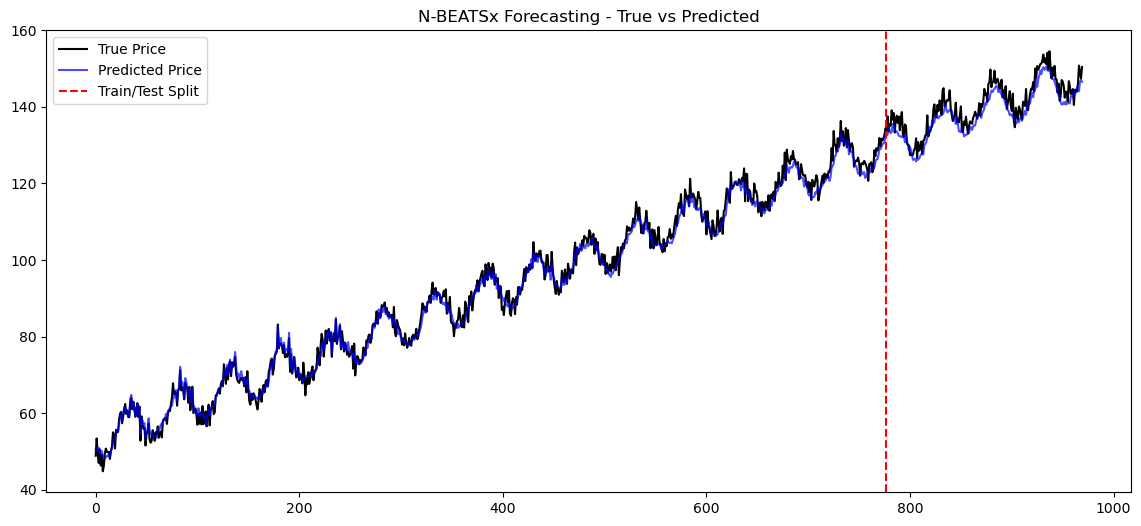


Block 1 (Trend) - Theta Sample:
[121.97785   21.97952   26.718401  -0.57645  105.654175  24.92597
  23.454302 -27.900267]

Block 2 (Seasonality) - Theta Sample:
[-0.38012353  2.3609166  -0.81566334  1.0492971  -0.6454474   0.9344564
  2.034342    1.4593997   1.6016712   0.7116447   0.8985498   0.777817  ]

Block 3 (Trend) - Theta Sample:
[ 4.2640824   1.1751232   0.6065678  -0.90141296  5.146664    2.5853143
  1.315392   -0.36262685]

Block 4 (Seasonality) - Theta Sample:
[ 0.23367262  0.8037058   0.25411552  0.97716427  0.20436963  0.41846228
  0.44135815  0.22400275  0.01677642 -0.28754386 -0.48891446  0.13835901]

Sample 1
True Price: 134.47, Predicted Price: 132.79
Trend Contribution: 126.24, Seasonality Contribution: 6.54

Block 1 (Trend) - Theta Sample:
[122.799614   21.823711   26.757504   -0.9059483 105.80501    25.280087
  23.54051   -27.958458 ]

Block 2 (Seasonality) - Theta Sample:
[-0.3117865   2.3998592  -0.9406785   1.0944241  -0.5705962   0.9834789
  2.0083225   1.7325

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.nbeatsx_v3 import NBeatsX  # Adjust if your filename is different

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Parameters
input_size = 30
exog_size = 3
forecast_size = 1
hidden_units = 256
num_blocks = 4
epochs = 50
batch_size = 32
learning_rate = 0.001

# Create synthetic dataset
np.random.seed(42)
n = 1000
t = np.arange(n)
price = 50 + 0.1 * t + 5 * np.sin(2 * np.pi * t / 50) + np.random.normal(scale=2, size=n)
df = pd.DataFrame({
    'Date': pd.date_range(start="2020-01-01", periods=n),
    'Price': price
})

# Data Preparation
def prepare_data(df, input_size, exog_size):
    prices = df["Price"].values
    dates = df["Date"].values

    # Generate synthetic exogenous factors
    exog_factors = np.random.uniform(0.9, 1.1, size=(len(prices), exog_size))

    X, Y, Exog = [], [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        Y.append(prices[i+input_size])
        Exog.append(exog_factors[i+input_size])
    
    X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))
    return X, Y.unsqueeze(1), Exog

X, Y, Exog = prepare_data(df, input_size, exog_size)

# Train/Test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]
Exog_train, Exog_test = Exog[:split_idx], Exog[split_idx:]

# Model
model = NBeatsX(
    input_size=input_size,
    exog_size=exog_size,
    forecast_size=forecast_size,
    hidden_units=hidden_units,
    num_blocks=num_blocks
).to(device)

# Training
def train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = Y_train[i:i+batch_size].to(device)
            exog_batch = Exog_train[i:i+batch_size].to(device)

            optimizer.zero_grad()
            preds = model(x_batch, exog_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss / (len(X_train) // batch_size))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {losses[-1]:.4f}")
    
    return losses

losses = train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, learning_rate)

# Evaluation
model.eval()
with torch.no_grad():
    preds_train = model(X_train.to(device), Exog_train.to(device)).cpu()
    preds_test = model(X_test.to(device), Exog_test.to(device)).cpu()

# Metrics
def mean_scaled_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred)) / torch.mean(torch.abs(y_true[1:] - y_true[:-1]))

def relative_squared_error(y_true, y_pred):
    return torch.sum((y_true - y_pred) ** 2) / torch.sum((y_true - torch.mean(y_true)) ** 2)

train_msae = mean_scaled_absolute_error(Y_train, preds_train).item()
test_msae = mean_scaled_absolute_error(Y_test, preds_test).item()
train_rse = relative_squared_error(Y_train, preds_train).item()
test_rse = relative_squared_error(Y_test, preds_test).item()

print(f"\nTrain MSAE: {train_msae:.4f}, Train RSE: {train_rse:.4f}")
print(f"Test MSAE: {test_msae:.4f}, Test RSE: {test_rse:.4f}")

# Plot
plt.figure(figsize=(14,6))
full_true = torch.cat([Y_train, Y_test], dim=0).numpy()
full_pred = torch.cat([preds_train, preds_test], dim=0).numpy()

plt.plot(full_true, label="True Price", color="black")
plt.plot(full_pred, label="Predicted Price", color="blue", alpha=0.7)
plt.axvline(x=split_idx, color="red", linestyle="--", label="Train/Test Split")
plt.title("N-BEATSx Forecasting - True vs Predicted")
plt.legend()
plt.show()

# Analyze Trend and Seasonality
def analyze_components(model, x_sample, exog_sample):
    model.eval()
    with torch.no_grad():
        total_forecast, thetas = model(x_sample.to(device), exog_sample.to(device), return_theta=True)
        
        trend_forecast = torch.zeros_like(total_forecast)
        seasonality_forecast = torch.zeros_like(total_forecast)
        residual = x_sample.to(device)

        for i, block in enumerate(model.blocks):
            backcast, block_forecast, theta = block(residual, exog_sample.to(device))
            residual = residual - backcast

            block_type = "Trend" if i % 2 == 0 else "Seasonality"
            print(f"\nBlock {i+1} ({block_type}) - Theta Sample:")
            print(theta[0].cpu().numpy())

            if i % 2 == 0:
                trend_forecast += block_forecast
            else:
                seasonality_forecast += block_forecast
        
        return trend_forecast.cpu(), seasonality_forecast.cpu()

# Visualize on a few test samples
n_samples = 5
for idx in range(n_samples):
    trend_comp, seasonality_comp = analyze_components(
        model, X_test[idx:idx+1], Exog_test[idx:idx+1]
    )

    true_price = Y_test[idx].item()
    pred_price = preds_test[idx].item()

    print(f"\nSample {idx+1}")
    print(f"True Price: {true_price:.2f}, Predicted Price: {pred_price:.2f}")
    print(f"Trend Contribution: {trend_comp.item():.2f}, Seasonality Contribution: {seasonality_comp.item():.2f}")


## NBEATSX V4 Test

Using device: cpu
Generating synthetic financial data...
Generating exogenous features...
Selected exogenous features: day_of_week, month, is_quarter_end, interest_rate, market_sentiment
Final dataset shape: (1500, 7)
        Date       Price  day_of_week  month  is_quarter_end  interest_rate  \
0 2020-01-01  100.496714            2      1               0       2.000000   
1 2020-01-02  101.639324            3      1               0       2.008607   
2 2020-01-03  103.066436            4      1               0       2.017211   
3 2020-01-04  103.162368            5      1               0       2.025810   
4 2020-01-05   99.743442            6      1               0       2.034401   

   market_sentiment  
0          0.353142  
1          0.082335  
2          0.229546  
3          0.569550  
4          1.152308  

Checking for NaN values in the dataset:
Date                0
Price               0
day_of_week         0
month               0
is_quarter_end      0
interest_rate       0
ma

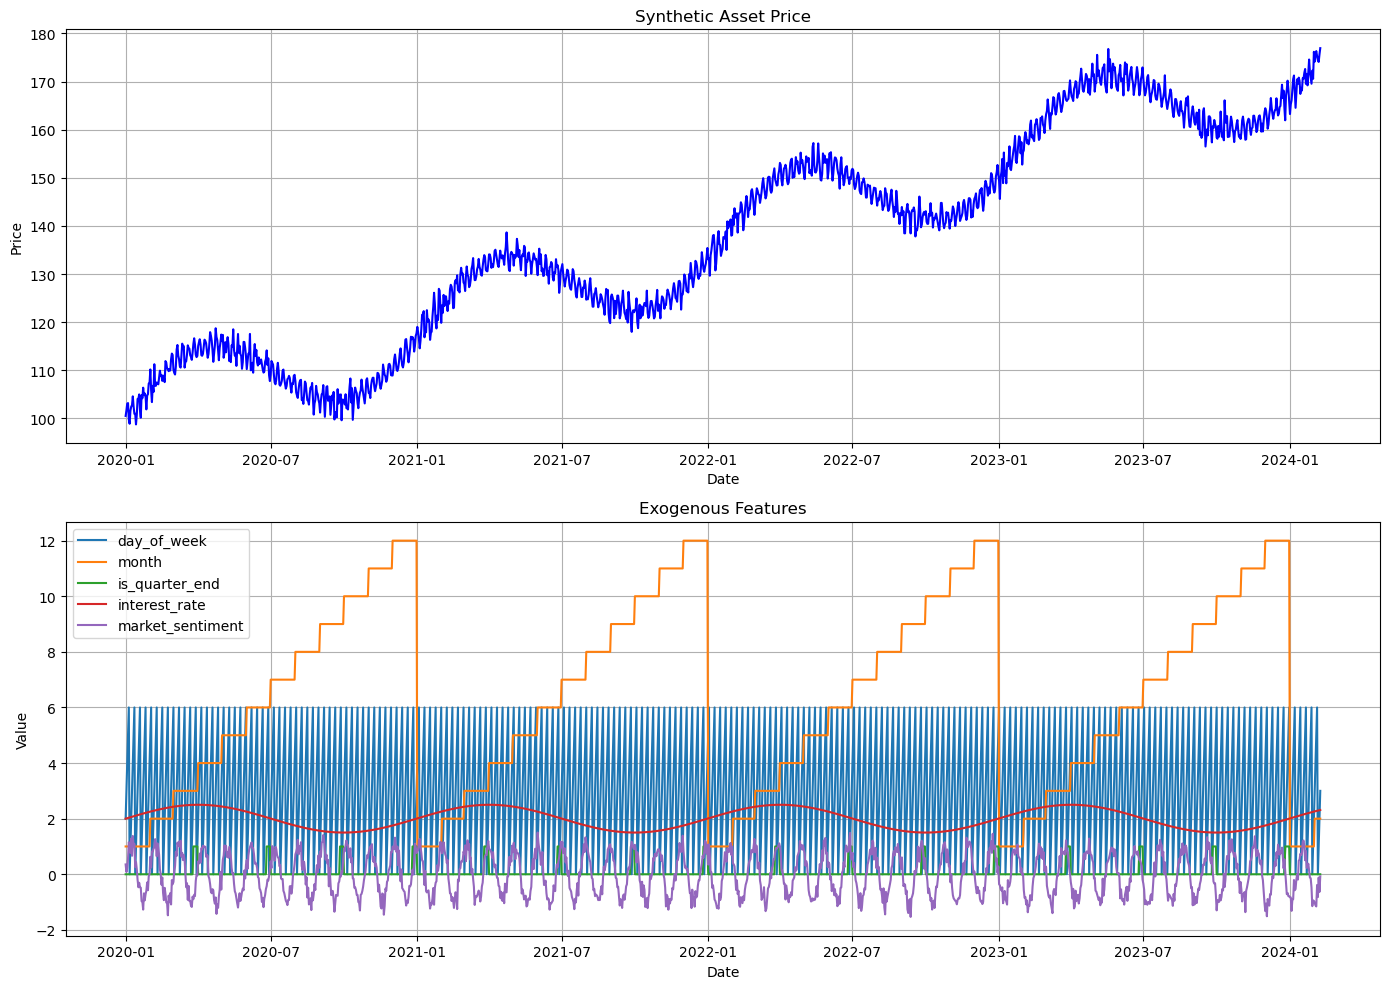


Data Parameters:
Input size (lookback): 30 days
Forecast horizon: 5 days
Exogenous features per time step: 5
Total exogenous size: 25

Preparing dataset...
Data prepared - X: torch.Size([1466, 30]), y: torch.Size([1466, 5]), e: torch.Size([1466, 25])
Train set: 1026 samples
Validation set: 219 samples
Test set: 221 samples
Model created with 413325 parameters
Created dataloaders with batch size 32
Training steps per epoch: 33
Setup complete! Dataset and model are ready for training!


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict
from datetime import datetime, timedelta

# Assuming that NBEATSx model has been implemented correctly
# Import the NBEATSx model - update path as needed
from models.nbeatsx_v4 import NBeatsX

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================ DATA GENERATION ================
def generate_synthetic_financial_data(
    n_days: int = 1000,
    start_date: str = "2020-01-01",
    has_trend: bool = True,
    has_seasonality: bool = True,
    has_cyclicality: bool = True,
    noise_level: float = 0.5,
) -> pd.DataFrame:
    """
    Generate synthetic financial price data with trend, seasonality, cyclicality, and noise.
    """
    # Time vector
    t = np.arange(n_days)
    
    # Starting price
    base_price = 100.0
    
    # Trend component (slight upward trend)
    trend = 0.05 * t if has_trend else 0
    
    # Seasonality component (weekly pattern)
    weekly = 2.0 * np.sin(2 * np.pi * t / 7) if has_seasonality else 0
    
    # Cyclicality component (market cycles)
    cycle_period = n_days / 4  # 4 market cycles in the data
    cyclicality = 10.0 * np.sin(2 * np.pi * t / cycle_period) if has_cyclicality else 0
    
    # Volatility clustering (GARCH-like effect)
    vol = 1.0 + 0.5 * np.sin(2 * np.pi * t / 120)  # Volatility cycle
    noise = np.random.normal(0, noise_level, n_days) * vol
    
    # Jump components (occasional market shocks)
    jumps = np.zeros(n_days)
    n_jumps = int(n_days / 100)  # Approximately one jump per 100 days
    jump_idx = np.random.choice(n_days, n_jumps, replace=False)
    jump_sizes = np.random.uniform(-5, 5, n_jumps)
    jumps[jump_idx] = jump_sizes
    
    # Combined price series
    price = base_price + trend + weekly + cyclicality + noise + jumps
    
    # Create date range
    dates = pd.date_range(start=start_date, periods=n_days)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Price': price
    })
    
    return df

def generate_exogenous_features(n_days: int, dates: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Generate relevant exogenous features for financial data forecasting.
    
    Parameters:
    -----------
    n_days: Number of days
    dates: DatetimeIndex for the time series
    
    Returns:
    --------
    DataFrame with exogenous features
    """
    # Create DataFrame with date index
    df = pd.DataFrame(index=range(n_days))
    
    # Calendar features - extract from dates
    df['day_of_week'] = [date.dayofweek for date in dates]
    df['month'] = [date.month for date in dates]
    df['day_of_month'] = [date.day for date in dates]
    df['is_quarter_end'] = [1 if date.month in [3, 6, 9, 12] and date.day > 25 else 0 for date in dates]
    
    # Synthetic economic indicators
    t = np.arange(n_days)
    
    # Interest rate (slowly varying)
    df['interest_rate'] = 2.0 + 0.5 * np.sin(2 * np.pi * t / 365)
    
    # Market sentiment (more rapidly varying)
    df['market_sentiment'] = np.sin(2 * np.pi * t / 30) + 0.2 * np.random.randn(n_days)
    
    # Trading volume (weekly pattern with randomness)
    base_volume = 1.0 + 0.3 * np.sin(2 * np.pi * t / 7)
    vol_noise = 0.2 * np.random.randn(n_days)
    df['trading_volume'] = base_volume + vol_noise
    
    # Market volatility index
    df['volatility_index'] = 15 + 5 * np.sin(2 * np.pi * t / 90) + 2 * np.random.randn(n_days)
    
    # Economic surprise index (occasional jumps)
    eco_surprise = np.zeros(n_days)
    surprise_days = np.random.choice(n_days, n_days // 30, replace=False)
    surprise_vals = np.random.normal(0, 1, n_days // 30)
    eco_surprise[surprise_days] = surprise_vals
    df['eco_surprise'] = np.cumsum(eco_surprise) / 5
    
    return df

# Generate the synthetic data
print("Generating synthetic financial data...")
n_days = 1500
df_price = generate_synthetic_financial_data(
    n_days=n_days,
    start_date="2020-01-01",
    has_trend=True,
    has_seasonality=True,
    has_cyclicality=True,
    noise_level=1.0
)

# Generate exogenous features
print("Generating exogenous features...")
exog_features = generate_exogenous_features(
    n_days=n_days,
    dates=pd.to_datetime(df_price['Date'])
)

# Select only 5 features to use
selected_features = ['day_of_week', 'month', 'is_quarter_end', 'interest_rate', 'market_sentiment']
exog_features = exog_features[selected_features]
print(f"Selected exogenous features: {', '.join(selected_features)}")

# Create full dataframe for visualization
df = pd.concat([df_price.reset_index(drop=True), exog_features.reset_index(drop=True)], axis=1)
print(f"Final dataset shape: {df.shape}")
print(df.head())

# Check for NaN values
nan_check = df.isna().sum()
print("\nChecking for NaN values in the dataset:")
print(nan_check)

# Replace any NaN values if they exist
if df.isna().any().any():
    print("Replacing NaN values...")
    df = df.fillna(method='ffill').fillna(method='bfill')  # Forward fill then backward fill
    # Check again to verify
    nan_check_after = df.isna().sum()
    print("NaN values after replacement:")
    print(nan_check_after)

# Visualize the synthetic data
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Price'], color='blue')
plt.title('Synthetic Asset Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 1, 2)
# Plot exogenous features
for col in exog_features.columns:
    plt.plot(df['Date'], df[col], label=col)
plt.title('Exogenous Features')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('synthetic_data.png')
plt.show()

# ================ DATA PREPARATION ================
def prepare_data_with_exog(
    price_series: np.ndarray,
    exog_features: np.ndarray,
    input_size: int,
    forecast_size: int,
    stride: int = 1
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepare time series data with exogenous variables for training and testing.
    """
    X, y, e = [], [], []
    
    # Get total number of features
    n_exog = exog_features.shape[1]
    
    # Create sliding windows
    for i in range(0, len(price_series) - input_size - forecast_size + 1, stride):
        X.append(price_series[i:i+input_size])
        y.append(price_series[i+input_size:i+input_size+forecast_size])
        
        # For exogenous features, we combine features for all forecast steps
        e_sample = []
        for j in range(forecast_size):
            idx = i + input_size + j
            e_sample.extend(exog_features[idx])
        e.append(e_sample)
    
    # Convert to torch tensors
    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    e = torch.tensor(np.array(e), dtype=torch.float32)
    
    return X, y, e

# Define parameters
input_size = 30  # Look back 30 days
forecast_size = 5  # Forecast 5 days ahead
exog_size = exog_features.shape[1] * forecast_size  # Exog features for each forecast day

print(f"\nData Parameters:")
print(f"Input size (lookback): {input_size} days")
print(f"Forecast horizon: {forecast_size} days")
print(f"Exogenous features per time step: {exog_features.shape[1]}")
print(f"Total exogenous size: {exog_size}")

# Normalize the data
scaler_y = StandardScaler()
scaler_e = StandardScaler()

price_normalized = scaler_y.fit_transform(df['Price'].values.reshape(-1, 1)).flatten()
exog_normalized = scaler_e.fit_transform(exog_features.values)

# Prepare dataset
print("\nPreparing dataset...")
X, y, e = prepare_data_with_exog(
    price_normalized,
    exog_normalized,
    input_size=input_size,
    forecast_size=forecast_size
)

print(f"Data prepared - X: {X.shape}, y: {y.shape}, e: {e.shape}")

# Train/validation/test split (70/15/15)
n_samples = len(X)
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

X_train, y_train, e_train = X[:train_size], y[:train_size], e[:train_size]
X_val, y_val, e_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size], e[train_size:train_size+val_size]
X_test, y_test, e_test = X[train_size+val_size:], y[train_size+val_size:], e[train_size+val_size:]

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ================ MODEL SETUP ================
def create_nbeatsx_model(
    input_size: int,
    forecast_size: int,
    exog_size: int,
    hidden_units: int = 128,
    stack_config: List[Tuple[str, int]] = None
) -> NBeatsX:
    """
    Create an NBEATSx model with the given configuration.
    """
    if stack_config is None:
        # Default configuration
        stack_types = ['trend', 'seasonality', 'generic']
        num_blocks_per_stack = [2, 2, 1]
    else:
        stack_types, num_blocks_per_stack = zip(*stack_config)
    
    model = NBeatsX(
        input_size=input_size,
        forecast_size=forecast_size,
        exog_size=exog_size,
        stack_types=stack_types,
        num_blocks_per_stack=num_blocks_per_stack,
        hidden_units=hidden_units,
        layers=4,
        trend_degree=4,
        seasonality_harmonics=5,
        dropout=0.1
    )
    
    return model

# Create the model
model = create_nbeatsx_model(
    input_size=input_size,
    forecast_size=forecast_size,
    exog_size=exog_size,
    hidden_units=128,
    stack_config=[
        ('trend', 2),
        ('seasonality', 2),
        ('generic', 1)
    ]
)

model = model.to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

# ================ DATALOADERS ================
# Create DataLoaders for training, validation, and testing
batch_size = 32

# Custom dataset class
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, e):
        self.X = X
        self.y = y
        self.e = e
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.e[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train, e_train)
val_dataset = TimeSeriesDataset(X_val, y_val, e_val)
test_dataset = TimeSeriesDataset(X_test, y_test, e_test)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

print(f"Created dataloaders with batch size {batch_size}")
print(f"Training steps per epoch: {len(train_loader)}")

# Save a sample of the data for visualization later
sample_x = X_test[:5].clone()
sample_e = e_test[:5].clone()
sample_y = y_test[:5].clone()

print("Setup complete! Dataset and model are ready for training!")

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training NBEATSx model for 50 epochs...
Learning rate: 0.001, Weight decay: 1e-05
Using MSELoss loss and Adam optimizer
Early stopping patience: 10, LR scheduler: ReduceLROnPlateau
Epoch 1/50 - Saved best model with val_loss: 0.0481
Epoch 1/50 - Train Loss: 0.0875, Val Loss: 0.0481, LR: 0.001000, Time: 0.44s
Epoch 2/50 - Train Loss: 0.0112, Val Loss: 0.0784, LR: 0.001000, Time: 0.36s
Epoch 3/50 - Saved best model with val_loss: 0.0325
Epoch 3/50 - Train Loss: 0.0077, Val Loss: 0.0325, LR: 0.001000, Time: 0.40s
Epoch 4/50 - Train Loss: 0.0062, Val Loss: 0.0368, LR: 0.001000, Time: 0.30s
Epoch 5/50 - Train Loss: 0.0058, Val Loss: 0.0378, LR: 0.001000, Time: 0.33s
Epoch 6/50 - Saved best model with val_loss: 0.0263
Epoch 6/50 - Train Loss: 0.0052, Val Loss: 0.0263, LR: 0.001000, Time: 0.34s
Epoch 7/50 - Train Loss: 0.0053, Val Loss: 0.0266, LR: 0.001000, Time: 0.30s
Epoch 8/50 - Train Loss: 0.0049, Val Loss: 0.0361, LR: 0.001000, Time: 0.30s
Epoch 9/50 - Train Loss: 0.0049, Val Loss: 0.04

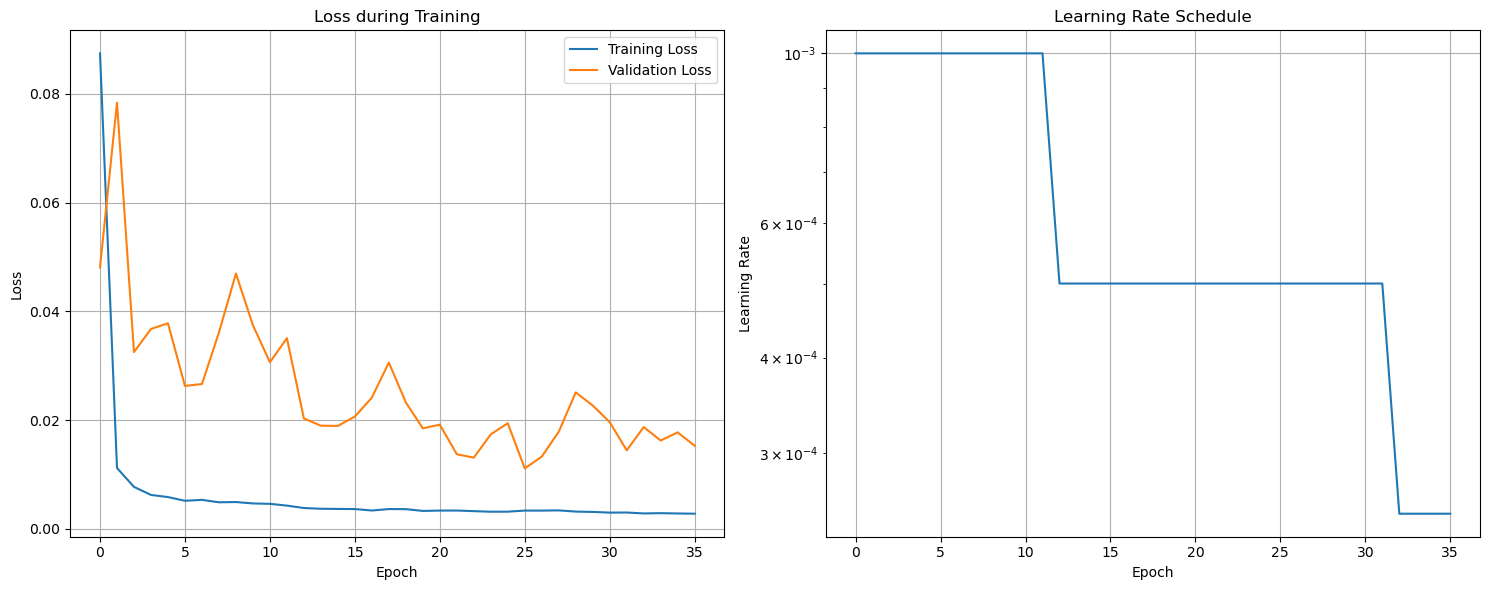


Plotting forecast examples...


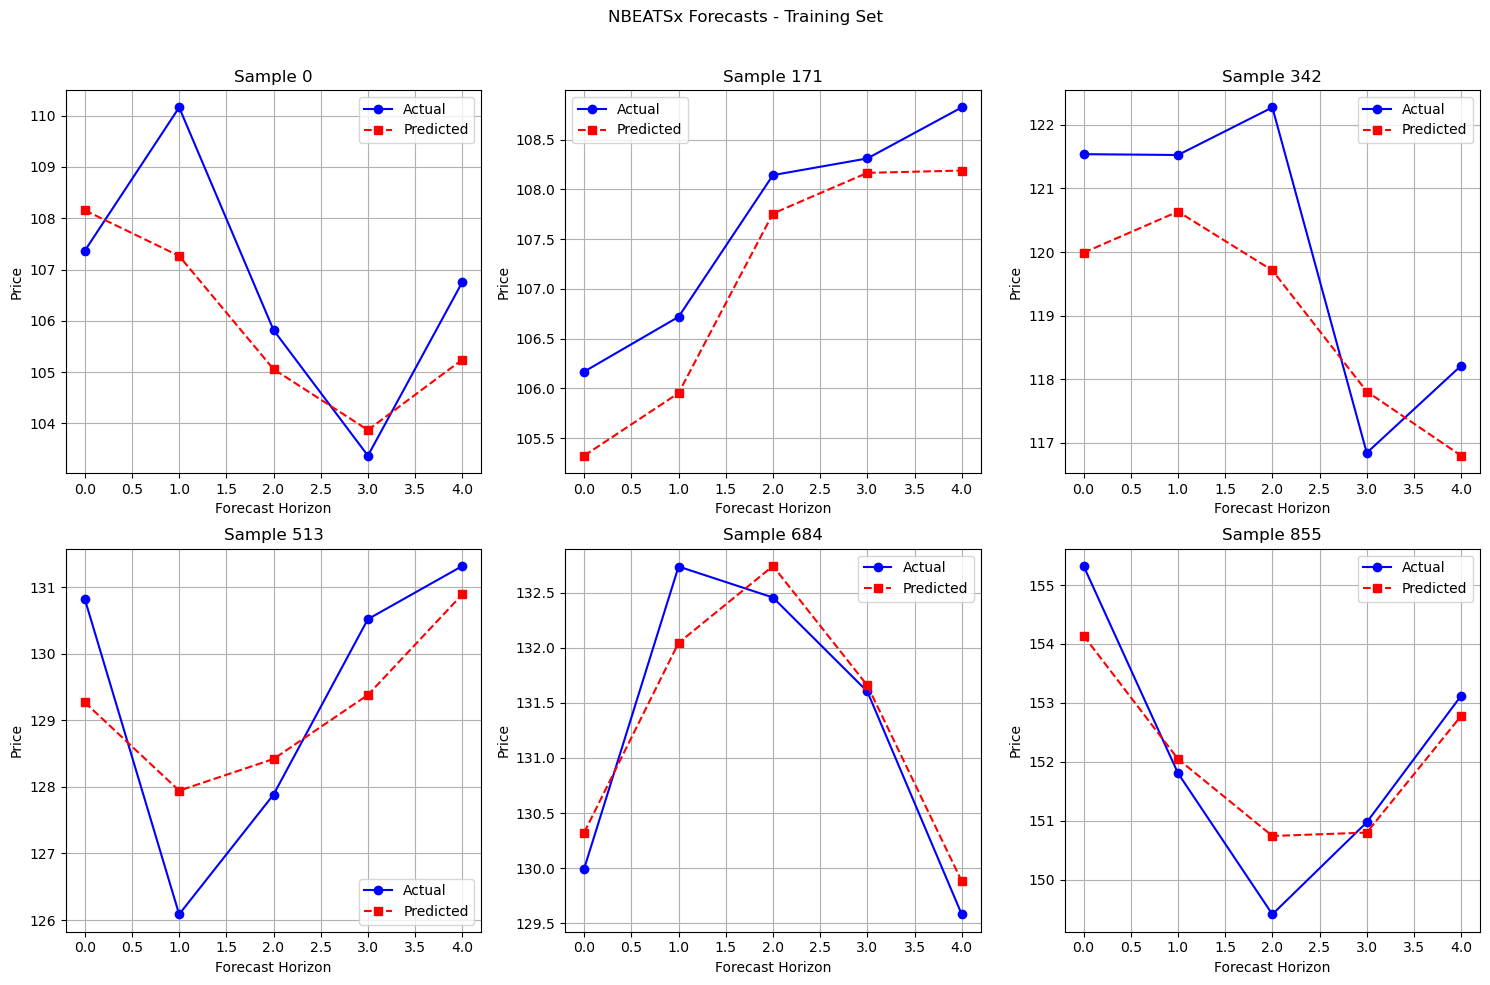

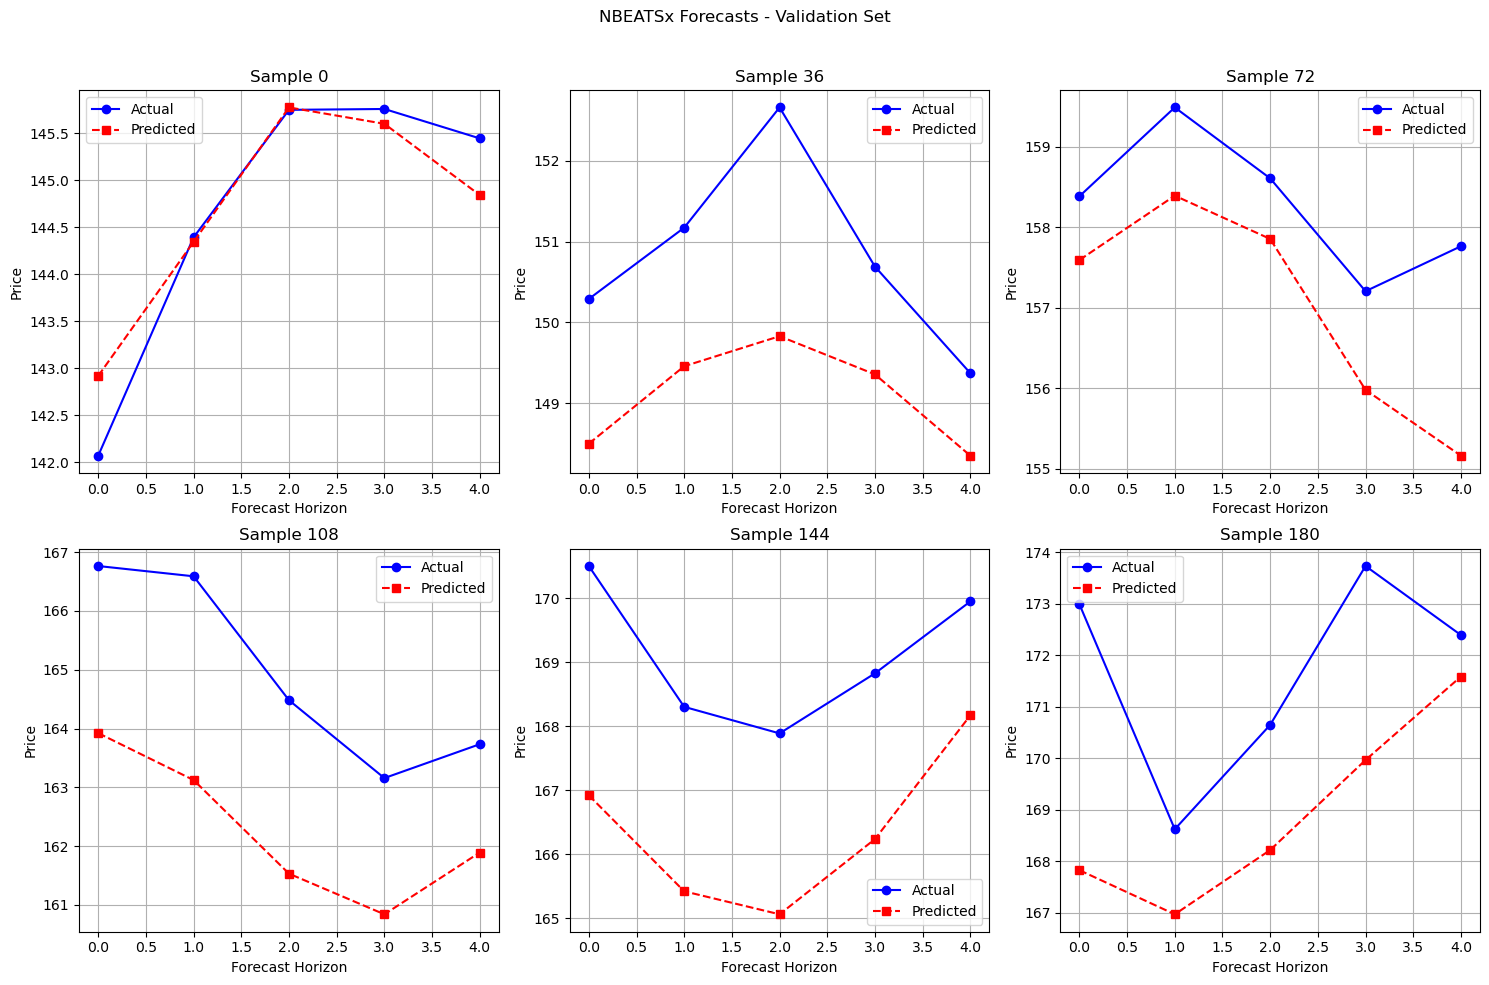

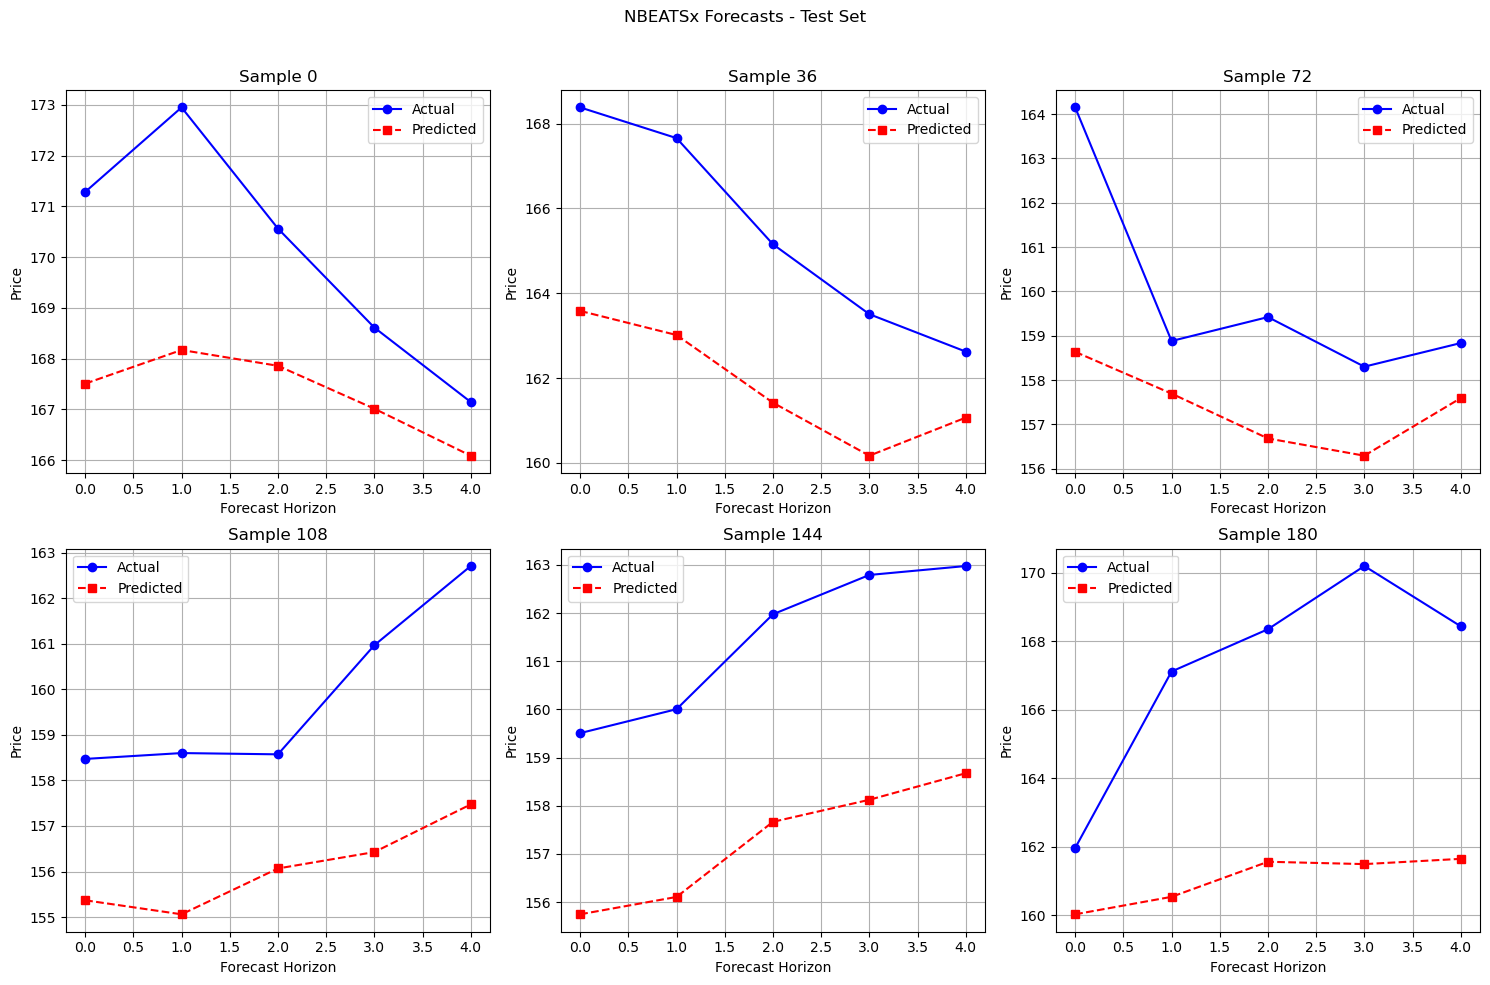


Analyzing model components...


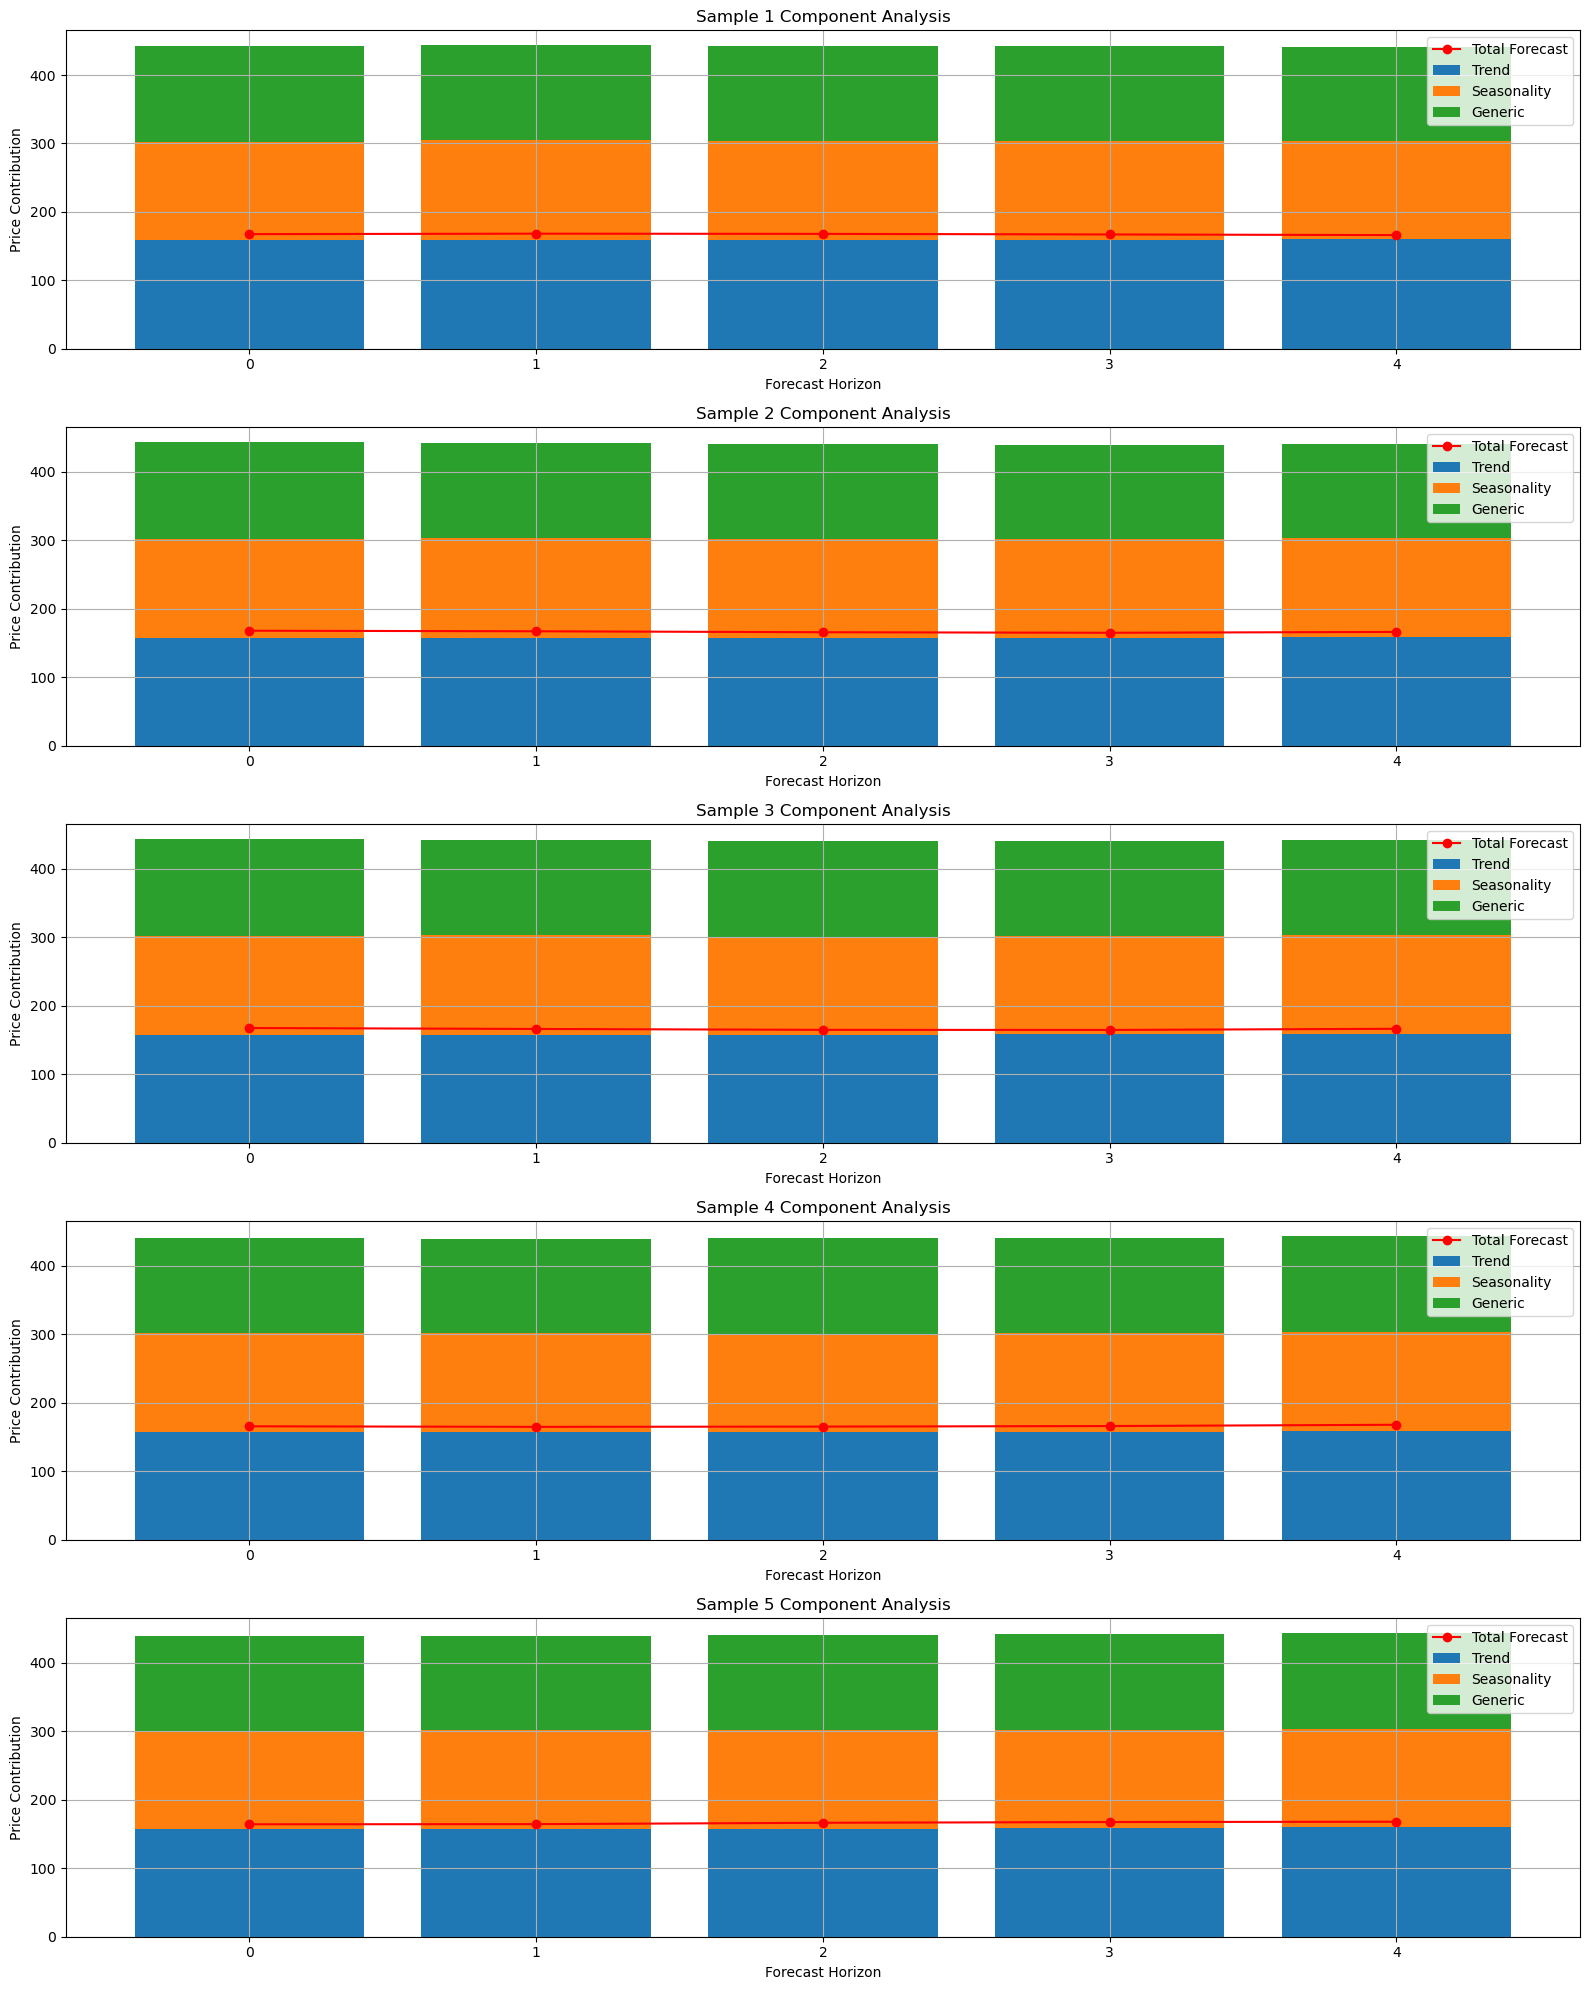


Component Contribution Analysis:

Sample 1:
Trend Stack: 71.60% (positive)
Seasonality Stack: 23.51% (positive)
Generic Stack: 4.89% (positive)

Sample 2:
Trend Stack: 70.14% (positive)
Seasonality Stack: 24.93% (positive)
Generic Stack: 4.93% (positive)

Sample 3:
Trend Stack: 72.13% (positive)
Seasonality Stack: 22.56% (positive)
Generic Stack: 5.31% (positive)

Sample 4:
Trend Stack: 70.48% (positive)
Seasonality Stack: 23.74% (positive)
Generic Stack: 5.78% (positive)

Sample 5:
Trend Stack: 72.49% (positive)
Seasonality Stack: 21.98% (positive)
Generic Stack: 5.52% (positive)

Analyzing component evolution over time...


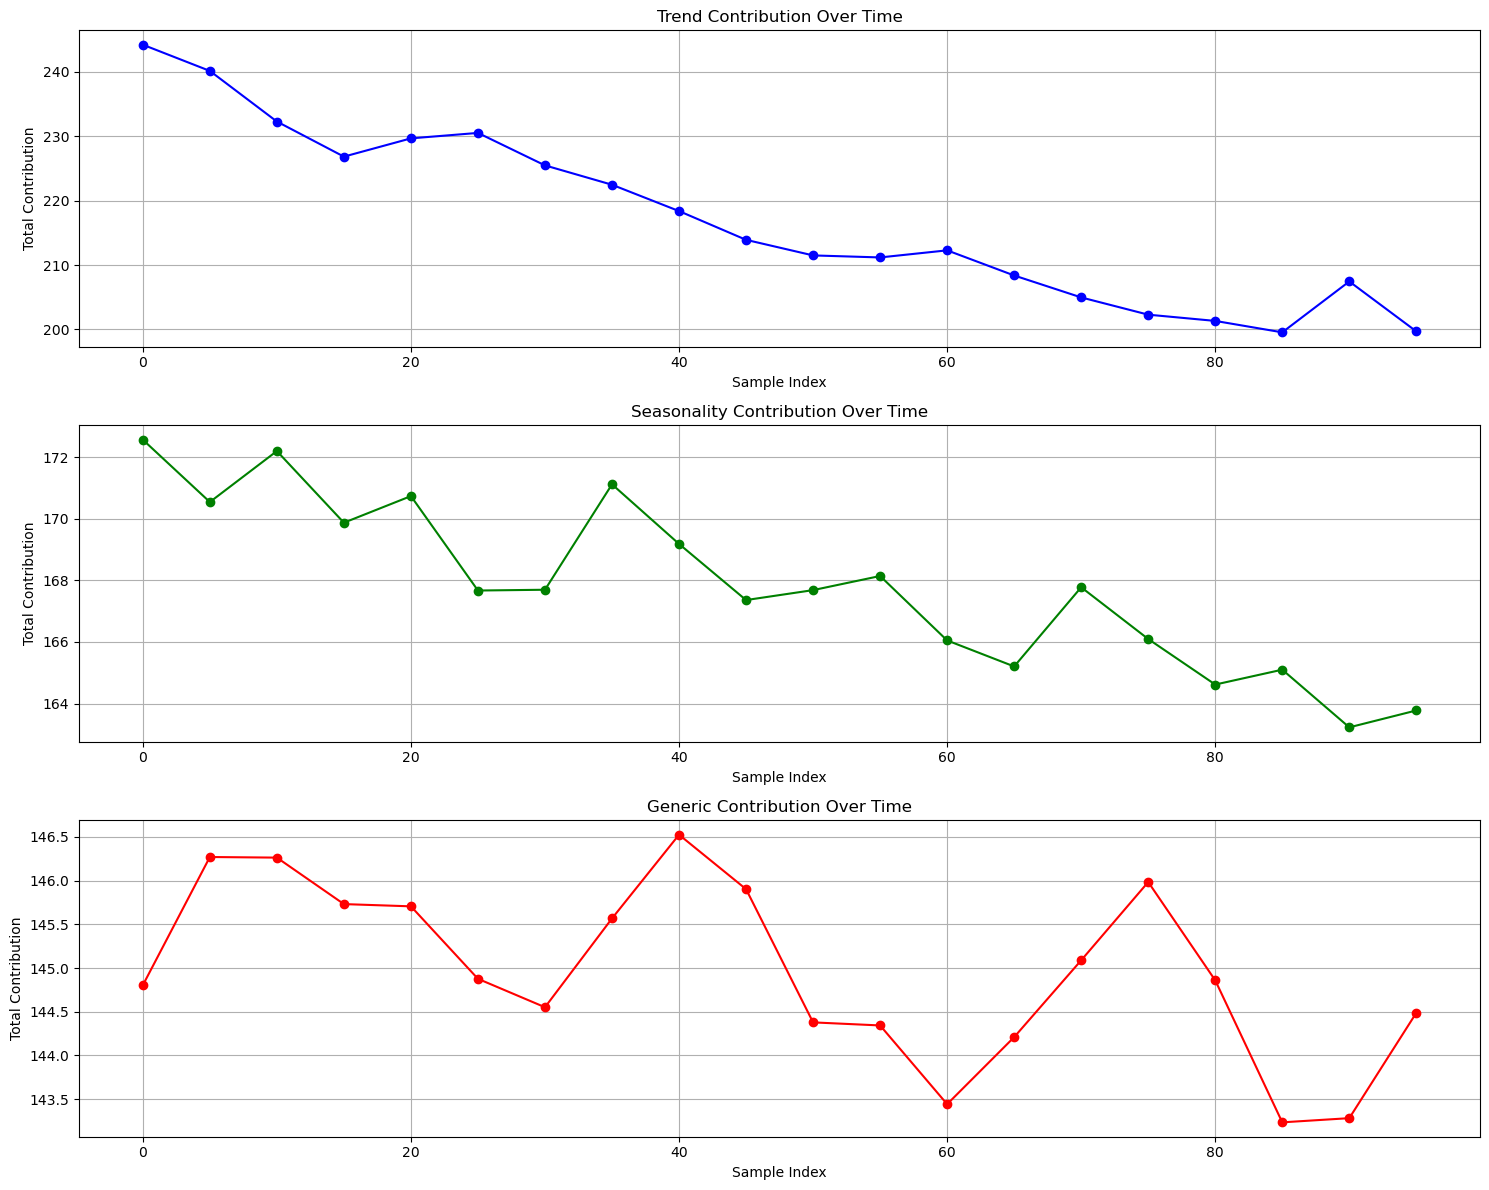


Analyzing model coefficients...


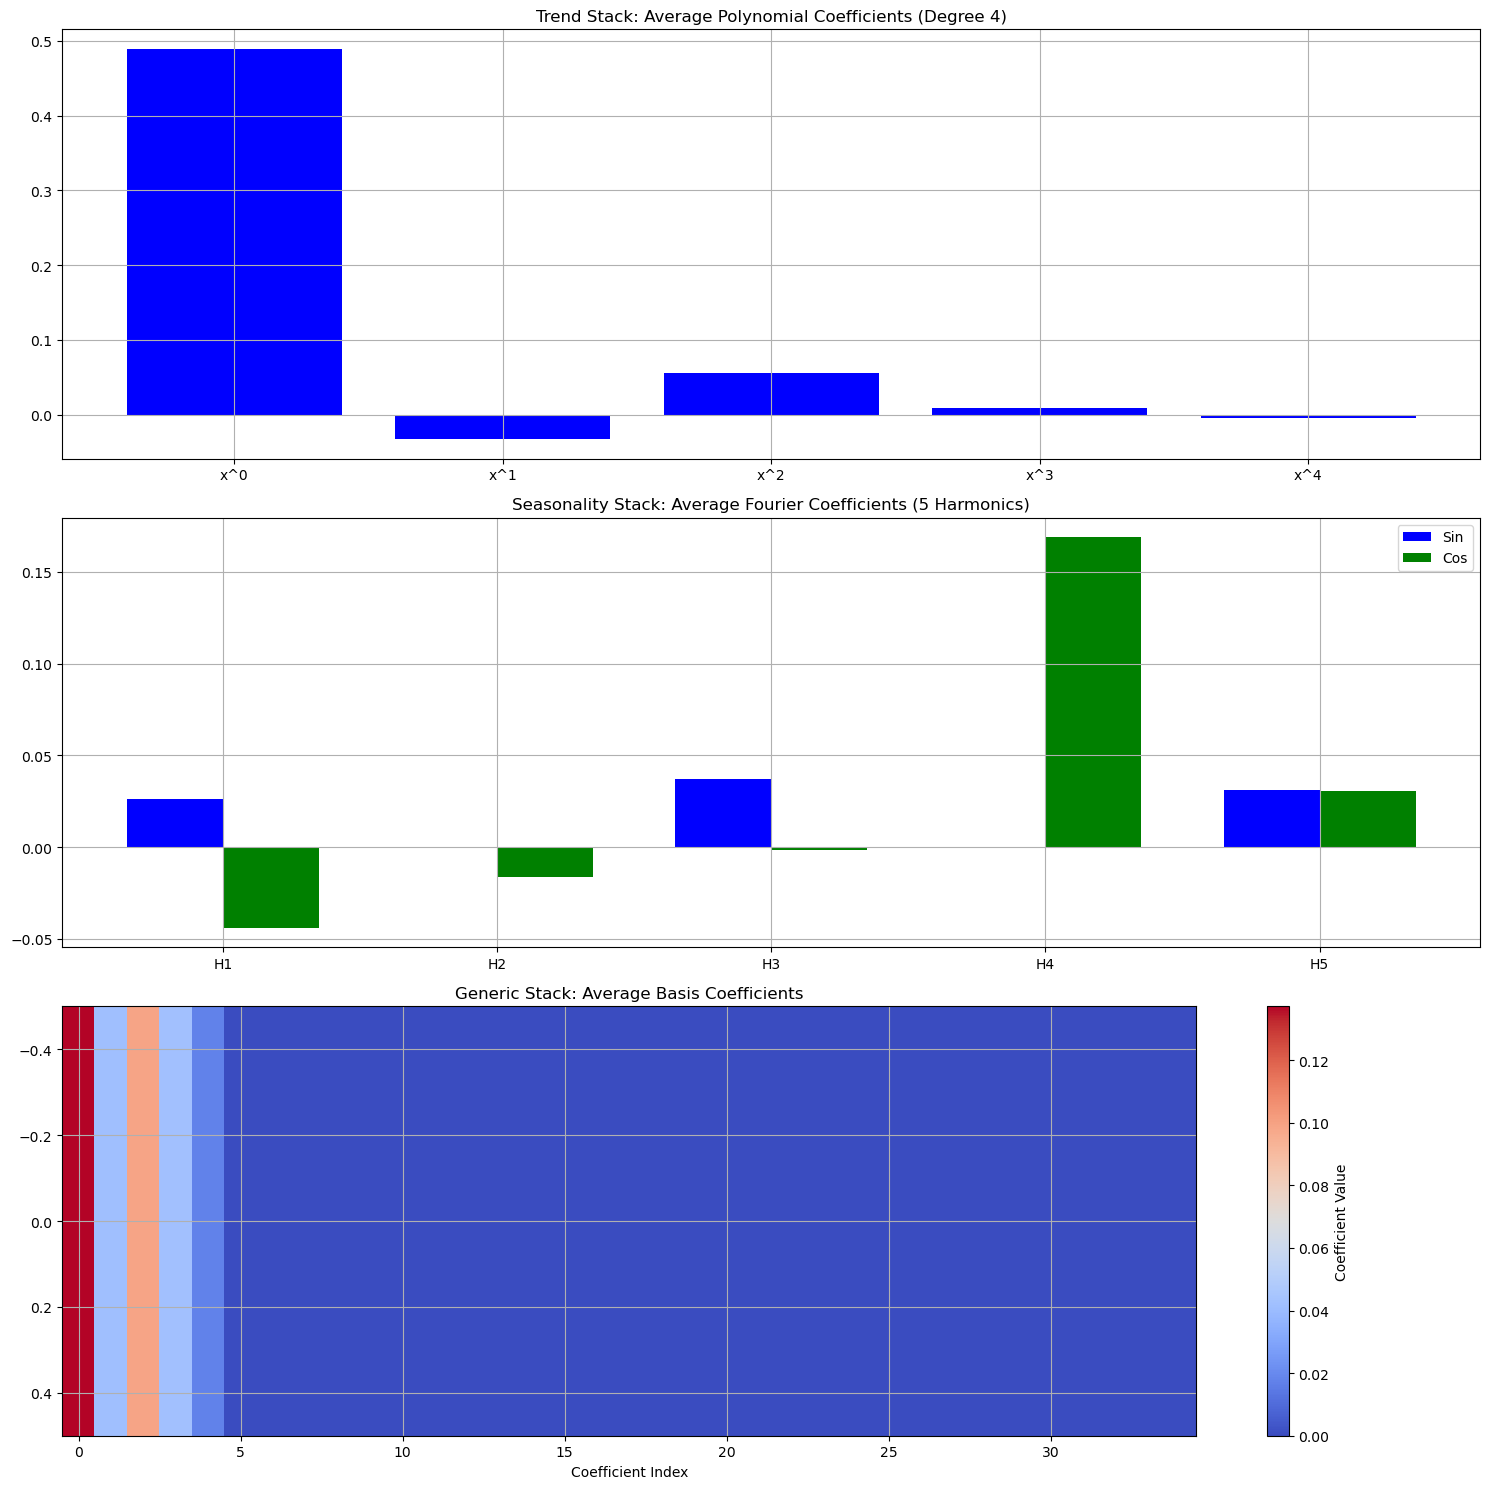


Analyzing exogenous variable importance...


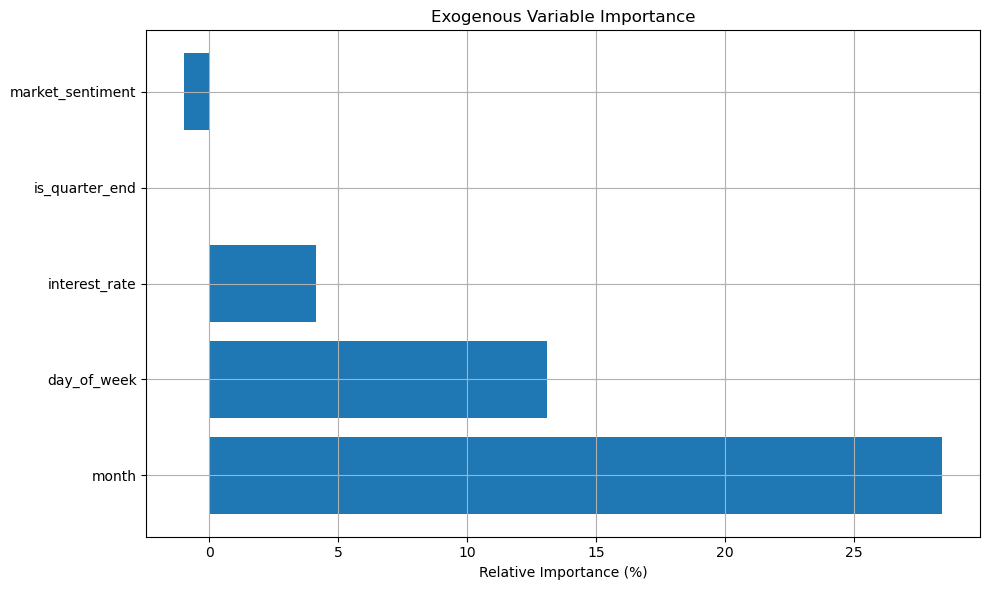


Exogenous Variable Importance:
month: 28.41%
day_of_week: 13.09%
interest_rate: 4.15%
is_quarter_end: 0.04%
market_sentiment: -0.97%

NBEATSx model analysis complete!


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from typing import Dict, List, Union

# Assuming we have the model, dataloaders, and variables from the previous script

# ================ TRAINING FUNCTIONS ================
def train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device
) -> float:
    """Train the model for one epoch and return the average loss."""
    model.train()
    total_loss = 0
    
    for batch_idx, (x_batch, y_batch, e_batch) in enumerate(dataloader):
        x_batch, y_batch, e_batch = x_batch.to(device), y_batch.to(device), e_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_batch, e_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def validate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> float:
    """Validate the model and return the average loss."""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for x_batch, y_batch, e_batch in dataloader:
            x_batch, y_batch, e_batch = x_batch.to(device), y_batch.to(device), e_batch.to(device)
            y_pred = model(x_batch, e_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler,  # Type hint removed since various schedulers can be used
    num_epochs: int,
    patience: int,
    device: torch.device,
    model_path: str = "best_nbeatsx_model.pth"
) -> Dict[str, List[float]]:
    """
    Train the model with early stopping and learning rate scheduling.
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }
    
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validation
        val_loss = validate(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rate'].append(current_lr)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), model_path)
            print(f"Epoch {epoch+1}/{num_epochs} - Saved best model with val_loss: {val_loss:.4f}")
        else:
            counter += 1
            
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    model.load_state_dict(torch.load(model_path))
    return history

# ================ TRAINING THE MODEL ================
# Set training parameters
num_epochs = 50
learning_rate = 0.001
weight_decay = 1e-5
patience = 10
model_path = "best_nbeatsx_model.pth"

# Define loss function, optimizer and scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print(f"Training NBEATSx model for {num_epochs} epochs...")
print(f"Learning rate: {learning_rate}, Weight decay: {weight_decay}")
print(f"Using {criterion.__class__.__name__} loss and {optimizer.__class__.__name__} optimizer")
print(f"Early stopping patience: {patience}, LR scheduler: ReduceLROnPlateau")

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience,
    device=device,
    model_path=model_path
)

# ================ EVALUATION AND PREDICTION ================
def predict_full_dataset(
    model: nn.Module,
    X: torch.Tensor,
    e: torch.Tensor,
    device: torch.device
) -> torch.Tensor:
    """
    Generate predictions for the entire dataset.
    """
    model.eval()
    
    # Process in batches to avoid memory issues
    batch_size = 128
    n_samples = X.shape[0]
    y_pred = []
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            X_batch = X[i:end_idx].to(device)
            e_batch = e[i:end_idx].to(device)
            
            pred = model(X_batch, e_batch)
            y_pred.append(pred.cpu())
    
    return torch.cat(y_pred, dim=0)

def compute_metrics(y_true: torch.Tensor, y_pred: torch.Tensor) -> Dict[str, float]:
    """
    Compute regression metrics for evaluation.
    """
    # Convert to numpy
    y_true_np = y_true.numpy()
    y_pred_np = y_pred.numpy()
    
    # Compute metrics for each forecast step
    metrics_by_step = {}
    horizon = y_true.shape[1]
    
    for step in range(horizon):
        true_step = y_true_np[:, step]
        pred_step = y_pred_np[:, step]
        
        mae = mean_absolute_error(true_step, pred_step)
        mse = mean_squared_error(true_step, pred_step)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_step, pred_step)
        
        # Mean absolute percentage error (with epsilon to avoid division by zero)
        mape = np.mean(np.abs((true_step - pred_step) / (np.abs(true_step) + 1e-5))) * 100
        
        metrics_by_step[f'step_{step+1}'] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2,
            'MAPE (%)': mape
        }
    
    # Compute overall metrics
    y_true_flat = y_true_np.flatten()
    y_pred_flat = y_pred_np.flatten()
    
    overall_mae = mean_absolute_error(y_true_flat, y_pred_flat)
    overall_mse = mean_squared_error(y_true_flat, y_pred_flat)
    overall_rmse = np.sqrt(overall_mse)
    overall_r2 = r2_score(y_true_flat, y_pred_flat)
    overall_mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (np.abs(y_true_flat) + 1e-5))) * 100
    
    metrics = {
        'overall': {
            'MAE': overall_mae,
            'MSE': overall_mse,
            'RMSE': overall_rmse,
            'R²': overall_r2,
            'MAPE (%)': overall_mape
        },
        'by_step': metrics_by_step
    }
    
    return metrics

# Get predictions for training, validation, and test sets
print("\nGenerating predictions...")
train_preds = predict_full_dataset(model, X_train, e_train, device)
val_preds = predict_full_dataset(model, X_val, e_val, device)
test_preds = predict_full_dataset(model, X_test, e_test, device)

# Compute metrics
print("\nComputing evaluation metrics...")
train_metrics = compute_metrics(y_train, train_preds)
val_metrics = compute_metrics(y_val, val_preds)
test_metrics = compute_metrics(y_test, test_preds)

# Print overall metrics
print("\nOverall Metrics:")
print("-" * 50)
print(f"{'Metric':<10} {'Train':<10} {'Validation':<10} {'Test':<10}")
print("-" * 50)

for metric in ['MAE', 'RMSE', 'R²', 'MAPE (%)']:
    train_val = train_metrics['overall'][metric]
    val_val = val_metrics['overall'][metric]
    test_val = test_metrics['overall'][metric]
    print(f"{metric:<10} {train_val:<10.4f} {val_val:<10.4f} {test_val:<10.4f}")

# Print metrics by forecast step for test set
print("\nTest Metrics by Forecast Step:")
print("-" * 70)
print(f"{'Step':<6} {'MAE':<10} {'RMSE':<10} {'R²':<10} {'MAPE (%)':<10}")
print("-" * 70)

for step in range(forecast_size):
    step_metrics = test_metrics['by_step'][f'step_{step+1}']
    print(f"{step+1:<6} {step_metrics['MAE']:<10.4f} {step_metrics['RMSE']:<10.4f} "
          f"{step_metrics['R²']:<10.4f} {step_metrics['MAPE (%)']:<10.4f}")

# ================ VISUALIZATION ================
def plot_training_history(history: Dict[str, List[float]]) -> None:
    """Plot the training history."""
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['learning_rate'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_forecast_results(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    scaler_y: object,
    dataset_name: str,
    indices: List[int] = None
) -> None:
    """
    Plot the forecast results for specific samples.
    """
    if indices is None:
        indices = range(len(y_true))
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices[:min(6, len(indices))]):
        plt.subplot(2, 3, i+1)
        
        # Convert to original scale
        true_vals = scaler_y.inverse_transform(y_true[idx].reshape(-1, 1)).flatten()
        pred_vals = scaler_y.inverse_transform(y_pred[idx].reshape(-1, 1)).flatten()
        
        horizon = len(true_vals)
        x_vals = range(horizon)
        
        plt.plot(x_vals, true_vals, 'o-', label='Actual', color='blue')
        plt.plot(x_vals, pred_vals, 's--', label='Predicted', color='red')
        plt.title(f'Sample {idx}')
        plt.xlabel('Forecast Horizon')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend()
    
    plt.suptitle(f'NBEATSx Forecasts - {dataset_name} Set')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'forecast_results_{dataset_name.lower()}.png')
    plt.show()

# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Plot forecast results for a few samples from each dataset
print("\nPlotting forecast examples...")
plot_forecast_results(y_train, train_preds, scaler_y, "Training", indices=range(0, len(y_train), len(y_train)//6)[:6])
plot_forecast_results(y_val, val_preds, scaler_y, "Validation", indices=range(0, len(y_val), len(y_val)//6)[:6])
plot_forecast_results(y_test, test_preds, scaler_y, "Test", indices=range(0, len(y_test), len(y_test)//6)[:6])

# ================ COMPONENT ANALYSIS ================
def analyze_components(
    model,  # NBEATSx model 
    sample_x: torch.Tensor,
    sample_e: torch.Tensor,
    scaler_y: object,
    device: torch.device
) -> None:
    """
    Analyze forecast components from different stacks.
    """
    model.eval()
    n_samples = len(sample_x)
    
    plt.figure(figsize=(16, 4 * n_samples))
    
    with torch.no_grad():
        # Get forecast and components
        forecast, components = model(sample_x.to(device), sample_e.to(device), return_components=True)
        
        # Number of different stack types
        n_stacks = len(components)
        stack_names = ['Trend', 'Seasonality', 'Generic']
        
        # Analyze each sample
        for i in range(n_samples):
            plt.subplot(n_samples, 1, i+1)
            
            # Get the original scale forecast
            total_forecast = scaler_y.inverse_transform(forecast[i].cpu().numpy().reshape(-1, 1)).flatten()
            
            # Gather component contributions in original scale
            component_forecasts = []
            for comp in components:
                comp_forecast = scaler_y.inverse_transform(comp[i].cpu().numpy().reshape(-1, 1)).flatten()
                component_forecasts.append(comp_forecast)
            
            # Plot stacked components
            x_horizon = np.arange(forecast.shape[1])
            bottom = np.zeros_like(total_forecast)
            
            for j, comp_forecast in enumerate(component_forecasts):
                plt.bar(x_horizon, comp_forecast, bottom=bottom, 
                       label=f'{stack_names[j] if j < len(stack_names) else f"Stack {j}"}')
                bottom += comp_forecast
            
            # Plot total forecast line
            plt.plot(x_horizon, total_forecast, 'ro-', label='Total Forecast')
            
            plt.title(f'Sample {i+1} Component Analysis')
            plt.xlabel('Forecast Horizon')
            plt.ylabel('Price Contribution')
            plt.legend()
            plt.grid(True)
        
    plt.tight_layout()
    plt.savefig('component_analysis.png')
    plt.show()
    
    # Print component contributions as percentages
    print("\nComponent Contribution Analysis:")
    for i in range(n_samples):
        print(f"\nSample {i+1}:")
        total_abs_contribution = sum(np.abs(comp[i].cpu().sum().item()) for comp in components)
        
        for j, comp in enumerate(components):
            comp_sum = comp[i].cpu().sum().item()
            contribution_pct = (np.abs(comp_sum) / total_abs_contribution) * 100
            direction = "positive" if comp_sum >= 0 else "negative"
            
            stack_name = stack_names[j] if j < len(stack_names) else f"Stack {j}"
            print(f"{stack_name} Stack: {contribution_pct:.2f}% ({direction})")

def plot_forecast_decomposition_over_time(
    model,  # NBEATSx model
    X: torch.Tensor,
    e: torch.Tensor,
    device: torch.device,
    scaler_y: object,
    input_size: int,
    start_idx: int = 0,
    num_forecasts: int = 30,
    stride: int = 10
) -> None:
    """
    Plot forecast decomposition for multiple forecasts over time.
    """
    model.eval()
    
    # Get stack types from model
    stack_names = ['Trend', 'Seasonality', 'Generic']
    n_stacks = len(model.stacks)
    
    # Create a figure with subplots for each stack
    plt.figure(figsize=(15, 4 * n_stacks))
    
    # We'll keep track of component contributions over time
    time_points = []
    stack_contributions = [[] for _ in range(n_stacks)]
    
    with torch.no_grad():
        for i in range(num_forecasts):
            idx = start_idx + i * stride
            if idx >= len(X):
                break
                
            # Get sample
            x_sample = X[idx:idx+1].to(device)
            e_sample = e[idx:idx+1].to(device)
            
            # Get forecast and components
            _, components = model(x_sample, e_sample, return_components=True)
            
            # Track time point
            time_points.append(idx)
            
            # Track component contributions
            for j, comp in enumerate(components):
                # Sum over forecast horizon
                contribution = comp[0].cpu().sum().item()
                stack_contributions[j].append(contribution)
    
    # Plot contribution of each stack over time
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for i in range(n_stacks):
        plt.subplot(n_stacks, 1, i+1)
        
        # Convert to original scale
        contributions = np.array(stack_contributions[i])
        contributions_orig = scaler_y.inverse_transform(contributions.reshape(-1, 1)).flatten()
        
        plt.plot(time_points, contributions_orig, 'o-', color=colors[i % len(colors)])
        plt.title(f'{stack_names[i] if i < len(stack_names) else f"Stack {i}"} Contribution Over Time')
        plt.xlabel('Sample Index')
        plt.ylabel('Total Contribution')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('component_decomposition_over_time.png')
    plt.show()

# ================ MODEL EXPLANATION AND INTERPRETATION ================
def explain_model_coefficients(
    model,  # NBEATSx model
    sample_x: torch.Tensor,
    sample_e: torch.Tensor,
    device: torch.device
) -> None:
    """
    Explain the NBEATSx model by analyzing the learned coefficients.
    """
    model.eval()
    
    with torch.no_grad():
        # Forward pass with theta output
        _, all_thetas = model(sample_x.to(device), sample_e.to(device), return_thetas=True)
        
        # Create figure
        plt.figure(figsize=(15, 5 * len(model.stacks)))
        
        # Analyze thetas from each stack
        for stack_idx, (stack_thetas, stack) in enumerate(zip(all_thetas, model.stacks)):
            # Get stack type
            stack_type = stack.stack_type
            
            # Create subplot for this stack
            plt.subplot(len(model.stacks), 1, stack_idx + 1)
            
            if stack_type == 'trend':
                # For trend stack, we expect polynomial coefficients
                # Each block contributes, so we'll average them
                avg_theta = torch.mean(torch.stack([theta[0] for theta in stack_thetas]), dim=0)
                
                # The first half of theta is for forecast, second half for backcast
                forecast_degree = stack.blocks[0].basis.degree
                forecast_thetas = avg_theta[:forecast_degree + 1].cpu().numpy()
                
                # Plot polynomial coefficients
                plt.bar(range(len(forecast_thetas)), forecast_thetas, color='blue')
                plt.xticks(range(len(forecast_thetas)), [f'x^{i}' for i in range(len(forecast_thetas))])
                plt.title(f'Trend Stack: Average Polynomial Coefficients (Degree {forecast_degree})')
                
            elif stack_type == 'seasonality':
                # For seasonality stack, we expect Fourier coefficients
                # Each block contributes, so we'll average them
                avg_theta = torch.mean(torch.stack([theta[0] for theta in stack_thetas]), dim=0)
                
                # The first half of theta is for forecast, second half for backcast
                harmonics = stack.blocks[0].basis.harmonics
                forecast_thetas = avg_theta[:2 * harmonics].cpu().numpy()
                
                # Reshape to separate sin and cos components
                fourier_coefs = forecast_thetas.reshape(-1, 2)
                
                # Plot Fourier coefficients
                width = 0.35
                x = np.arange(harmonics)
                plt.bar(x - width/2, fourier_coefs[:, 0], width, label='Sin', color='blue')
                plt.bar(x + width/2, fourier_coefs[:, 1], width, label='Cos', color='green')
                plt.xticks(x, [f'H{i+1}' for i in range(harmonics)])
                plt.title(f'Seasonality Stack: Average Fourier Coefficients ({harmonics} Harmonics)')
                plt.legend()
                
            elif stack_type == 'generic':
                # For generic stack, we have identity basis with less interpretable coefficients
                # We'll visualize the pattern of coefficients
                avg_theta = torch.mean(torch.stack([theta[0] for theta in stack_thetas]), dim=0)
                
                # Plot the coefficient pattern as a heatmap
                plt.imshow(avg_theta.cpu().numpy().reshape(1, -1), aspect='auto', cmap='coolwarm')
                plt.colorbar(label='Coefficient Value')
                plt.title('Generic Stack: Average Basis Coefficients')
                plt.xlabel('Coefficient Index')
            
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('model_coefficients_explanation.png')
        plt.show()

# ================ EXOGENOUS VARIABLE ANALYSIS ================
def analyze_exogenous_importance(
    model,  # NBEATSx model
    X: torch.Tensor,
    e: torch.Tensor,
    y: torch.Tensor,
    exog_names: List[str],
    device: torch.device,
    n_samples: int = 100
) -> None:
    """
    Analyze the importance of exogenous variables using a permutation approach.
    """
    model.eval()
    
    # Select a subset of samples for analysis
    if n_samples < len(X):
        indices = np.random.choice(len(X), n_samples, replace=False)
        X_subset = X[indices].to(device)
        e_subset = e[indices].to(device)
        y_subset = y[indices].to(device)
    else:
        X_subset = X.to(device)
        e_subset = e.to(device)
        y_subset = y.to(device)
    
    # Get base predictions and error
    with torch.no_grad():
        base_preds = model(X_subset, e_subset)
        base_error = torch.mean((base_preds - y_subset) ** 2).item()
    
    # Analyze each exogenous variable
    exog_importance = []
    
    # Get number of exogenous variables
    # In our case, each forecast step has exog variables
    forecast_size = y_subset.shape[1]
    exog_per_step = e_subset.shape[1] // forecast_size
    
    for i in range(exog_per_step):
        # Create permuted versions for each forecast step
        e_permuted = e_subset.clone()
        
        for step in range(forecast_size):
            # Get the index in the flat exogenous tensor
            idx = i + step * exog_per_step
            
            # Permute this feature across samples
            perm_idx = torch.randperm(len(e_subset))
            e_permuted[:, idx] = e_subset[perm_idx, idx]
        
        # Get predictions with permuted feature
        with torch.no_grad():
            perm_preds = model(X_subset, e_permuted)
            perm_error = torch.mean((perm_preds - y_subset) ** 2).item()
        
        # Importance is the increase in error when permuting this feature
        importance = (perm_error - base_error) / base_error * 100
        exog_importance.append((exog_names[i], importance))
    
    # Sort by importance
    exog_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Plot importance
    plt.figure(figsize=(10, 6))
    names, values = zip(*exog_importance)
    plt.barh(names, values)
    plt.xlabel('Relative Importance (%)')
    plt.title('Exogenous Variable Importance')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('exogenous_importance.png')
    plt.show()
    
    # Print importance
    print("\nExogenous Variable Importance:")
    for name, importance in exog_importance:
        print(f"{name}: {importance:.2f}%")

# ================ PUT IT ALL TOGETHER ================
# Run component analysis on sample data
print("\nAnalyzing model components...")
analyze_components(model, sample_x, sample_e, scaler_y, device)

# Analyze component evolution over time
print("\nAnalyzing component evolution over time...")
plot_forecast_decomposition_over_time(
    model,
    X_test,
    e_test,
    device,
    scaler_y,
    input_size,
    start_idx=0,
    num_forecasts=20,
    stride=5
)

# Analyze model coefficients
print("\nAnalyzing model coefficients...")
explain_model_coefficients(model, sample_x, sample_e, device)

# Analyze exogenous variable importance
print("\nAnalyzing exogenous variable importance...")
exog_names = ['day_of_week', 'month', 'is_quarter_end', 'interest_rate', 'market_sentiment']
analyze_exogenous_importance(
    model,
    X_test,
    e_test,
    y_test,
    exog_names,
    device,
    n_samples=200
)

print("\nNBEATSx model analysis complete!")

Test Period Metrics:
MAE: 3.8305
MAPE: 2.3240%


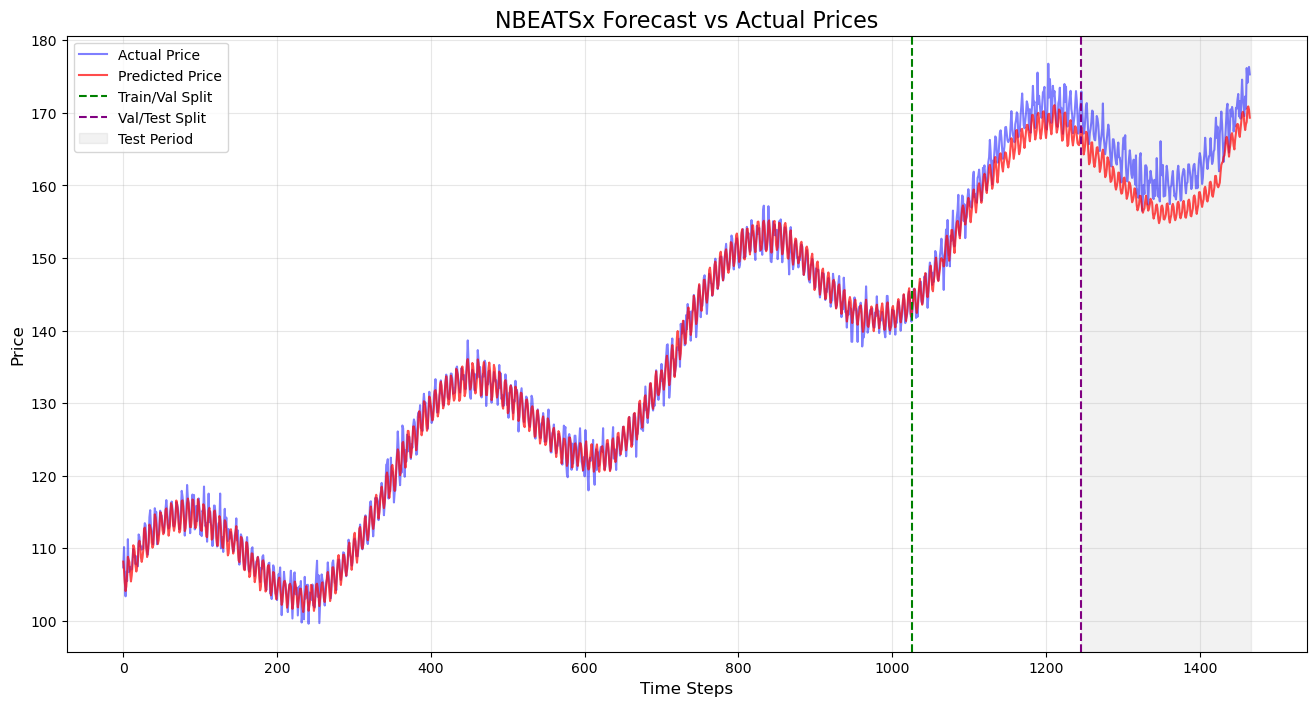

In [ ]:
# Plot the full price series with forecasts and train/test split
plt.figure(figsize=(16, 8))

# Inverse transform the data back to original scale
# Original price series
original_prices = scaler_y.inverse_transform(
    np.concatenate([y_train, y_val, y_test])[:, 0].reshape(-1, 1)
).flatten()

# Forecast prices
forecast_prices = scaler_y.inverse_transform(
    np.concatenate([train_preds, val_preds, test_preds])[:, 0].reshape(-1, 1)
).flatten()

# Time axis (sample indices)
time_idx = np.arange(len(original_prices))

# Plot full series
plt.plot(time_idx, original_prices, 'b-', alpha=0.5, label='Actual Price')
plt.plot(time_idx, forecast_prices, 'r-', alpha=0.7, label='Predicted Price')

# Add vertical lines for train/val/test splits
train_end = len(y_train)
val_end = train_end + len(y_val)

plt.axvline(x=train_end, color='g', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end, color='purple', linestyle='--', label='Val/Test Split')

# Highlight test region with light background
plt.axvspan(val_end, len(original_prices), alpha=0.1, color='gray', label='Test Period')

# Add labels and legend
plt.title('NBEATSx Forecast vs Actual Prices', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Print forecast accuracy in the test period
test_mae = mean_absolute_error(original_prices[val_end:], forecast_prices[val_end:])
test_mape = np.mean(np.abs((original_prices[val_end:] - forecast_prices[val_end:]) / original_prices[val_end:])) * 100

print(f"Test Period Metrics:")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.4f}%")


# Temporal Fusion Transformer V2 Accuracy Metrics

# Training MSE: 13.0708
# Training RMSE: 3.6154
# Training MAE: 2.2544
# Training MAPE: 1.6705%
# Training R²: 0.9781
# Test MSE: 135.9340
# Test RMSE: 11.6591
# Test MAE: 10.1551
# Test MAPE: 5.2392%
# Test R²: -0.4049